# Stock price prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This project is used to demonstrate skills in Machine Learning - building a regression model with time-series data.

The main idea of predicting the stock price obviously is to gain profit. However, this project is oriented on using price data only. To make predictions more accurate it would be better to collect data about other data withc could case the price change. So basically this project is more about *Technical analysis* (which is a set of tools for predicting likely price changes based on patterns of price changes in the past in similar circumstances) and not very applicable to real trading.

For building this model I will use a **LSTM** (*Long Short Term Memory Network*). I will try to predict stock prices of Apple.

The data is taken from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/stock-market-data

There also could be found data for other companies' stocks

### Importing Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.config import list_physical_devices
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import latest_checkpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Projects/stock-price-prediction/AAPL.csv')

Checking if I use Collab's GPU

In [4]:
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Preprocessing the data

In [5]:
data.head(3)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715


In [6]:
data.tail(3)

,Date,Low,Open,Volume,High,Close,Adjusted Close
10587,08-12-2022,141.100006,142.360001,62128300,143.520004,142.649994,142.649994
10588,09-12-2022,140.899994,142.339996,76069500,145.570007,142.160004,142.160004
10589,12-12-2022,141.070007,142.699997,21904917,143.000000,142.320007,142.320007


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 579.3+ KB


In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            10590 non-null  datetime64[ns]
 1   Low             10590 non-null  float64       
 2   Open            10590 non-null  float64       
 3   Volume          10590 non-null  int64         
 4   High            10590 non-null  float64       
 5   Close           10590 non-null  float64       
 6   Adjusted Close  10590 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 579.3 KB


To train model I will use the **Open Stock Price** column

In [10]:
data = data[['Date', 'Open']]

For building a model I will not use all the data since some for me old data seems irrelevant. It will be also hard to evaluate a model if test data wil include such a big period of time as many years. So at first I will try to make 1st January 2020 as the starting point. So the period is: from 2020-01-01 to 2022-12-12

In [11]:
data_filtered = data.loc[data['Date'] > '2020-01-01']

In [12]:
data_filtered.head(3)

,Date,Open
9847,2020-01-02,74.059998
9848,2020-01-03,74.287498
9849,2020-01-06,73.447502


I will also normalize the data

In [13]:
data_open = data_filtered.Open
data_open

9847      74.059998
9848      74.287498
9849      73.447502
9850      74.959999
9851      74.290001
            ...    
10585    147.070007
10586    142.190002
10587    142.360001
10588    142.339996
10589    142.699997
Name: Open, Length: 743, dtype: float64

In [14]:
scaler = MinMaxScaler(feature_range = (0.,1))
data_filtered['Open'] = scaler.fit_transform(data_filtered['Open'].values.reshape(-1,1))

<ipython-input-14-37cdf8fa0646>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Open'] = scaler.fit_transform(data_filtered['Open'].values.reshape(-1,1))


In [15]:
data.head(3)

,Date,Open
0,1980-12-12,0.128348
1,1980-12-15,0.122210
2,1980-12-16,0.113281


Creating train and test sets

In [16]:
TRAIN_SIZE = int(len(data_filtered)*0.8)
train_data = data_filtered.iloc[:TRAIN_SIZE]
test_data = data_filtered.iloc[TRAIN_SIZE:]

### Now I will create a function for creating sequences for training


In [17]:
def create_seq(data, sequence_length):
  '''
  Creates sequences for training
  '''
  sequences = []
  targets = []
  for i in range(len(data) - sequence_length):
    sequences.append(data[i:i+sequence_length])
    targets.append(data[i+sequence_length:i+sequence_length+1])
  return np.array(sequences), np.array(targets)

In [18]:
SEQUENCE_LENGTH = 10
X_train, y_train = create_seq(train_data['Open'], sequence_length=SEQUENCE_LENGTH)
X_test, y_test = create_seq(test_data['Open'], sequence_length=SEQUENCE_LENGTH)

### Building the LSTM model

In [19]:
def create_model():
  '''
  Creates an instance of a sequantial model, add layers and compile it.
  '''
  model = Sequential() # initializes a sequential model, which is a linear stack of layers.
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # This adds the first LSTM layer to the model. It has 50 units, returns sequences
  model.add(LSTM(units=50, return_sequences=False)) # adds the second LSTM layer, also with 50 units but does not return sequences
  model.add(Dense(units=25)) # adds a densely connected layer with 25 units.
  model.add(Dense(units=1)) # adds the output layer with a single unit, which will produce the predicted stock price

  model.compile(optimizer='adam', loss='mean_squared_error')


  return model

# Create a basic model instance
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


Now I will create callbacks that:
- Saves the model's weights every 3 epochs
- Stops fitting in case of no developing

In [20]:
checkpoint_path = "/content/drive/MyDrive/Projects/stock-price-prediction/checkpoints/cp-{epoch:04d}.ckpt" # Include the epoch in the file name (uses `str.format`
checkpoint_dir = os.path.dirname(checkpoint_path)

In [21]:
BATCH_SIZE = 32
EPOCHS = 30

In [22]:
import math
n_batches = len(X_train) / BATCH_SIZE
n_batches = math.ceil(n_batches)

In [23]:
# Saving the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [24]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=3*n_batches)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Training the model


In [26]:
# Calculate the number of batches per epoch

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_split=0.1, callbacks=[cp_callback, early_stopping])

Epoch 1/30
17/17 [==============================] - 13s 54ms/step - loss: 0.0709 - val_loss: 0.0076
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 4/30
 1/17 [>.............................] - ETA: 0s - loss: 0.0036
Epoch 4: saving model to /content/drive/MyDrive/Projects/stock-price-prediction/checkpoints/cp-0004.ckpt
17/17 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 7/30
10/17 [================>.............] - ETA: 0s - loss: 0.0014
Epoch 7: saving model to /content/drive/MyDrive/Projects/stock-price-prediction/checkpoints/cp-0007.ckpt
17/17 [==============================] - 0s 13ms/step - los

Now

In [27]:
os.listdir(checkpoint_dir)

['cp-0019.ckpt.data-00000-of-00001',
 'cp-0019.ckpt.index',
 'cp-0023.ckpt.data-00000-of-00001',
 'cp-0023.ckpt.index',
 'cp-0026.ckpt.data-00000-of-00001',
 'cp-0026.ckpt.index',
 'cp-0029.ckpt.data-00000-of-00001',
 'cp-0029.ckpt.index',
 'cp-0009.ckpt.index',
 'cp-0013.ckpt.index',
 'cp-0016.ckpt.index',
 'cp-0016.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0006.ckpt.index',
 'cp-0003.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'cp-0000.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0004.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.data-00000-of-00001',
 'checkpoint',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index']

In [28]:
latest = latest_checkpoint(checkpoint_dir)
latest

'/content/drive/MyDrive/Projects/stock-price-prediction/checkpoints/cp-0011.ckpt'

Now I will test, reset the model, and load the latest checkpoint:

In [29]:
model = create_model()

model.load_weights(latest)

# Re-evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Restored model, loss: {:5.2f}%".format(100 * score))

Restored model, loss:  0.22%


In [30]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [31]:
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)


## Evaluating the model

I will also show some statistics (MAE and MSE) for the model I got.

In [32]:
train_mae = mean_absolute_error(train_data.Open.iloc[SEQUENCE_LENGTH:], train_predictions)
test_mae = mean_absolute_error(test_data.Open.iloc[SEQUENCE_LENGTH:], test_predictions)
train_mse = mean_squared_error(train_data.Open.iloc[SEQUENCE_LENGTH:], train_predictions)
test_mse = mean_squared_error(test_data.Open.iloc[SEQUENCE_LENGTH:], test_predictions)
loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Loss: {loss:.2f}")


5/5 - 0s - loss: 0.0022 - 31ms/epoch - 6ms/step
Train MAE: 125.83, Test MAE: 149.68
Train MSE: 16835.62, Test MSE: 22489.11
Loss: 0.00


## Hyperparameter tuning

Before getting to visualiztion I will try to fine tune the model.

I will use manual hyperparameter tuning. For this I will have to create a fucntion that builds and trains the model with given hyperparameters.

In [33]:
def create_train_model(X, y, num_units, dropout_rate, learning_rate):
  '''
  Creates an instance of a sequantial model, add layers, compiles it,
  trains it and returns mse of validation set
  '''
  random.seed(42)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

  model = Sequential()
  # for _ in range(num_layers):
  #   model.add(LSTM(units=num_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  #   model.add(LSTM(units=50, return_sequences=False))
  #   model.add(Dropout(dropout_rate))
  # model.add(Dense(units=25))
  # model.add(Dense(units=1))

  model = Sequential() # initializes a sequential model, which is a linear stack of layers.
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # This adds the first LSTM layer to the model. It has 50 units, returns sequences
  model.add(LSTM(units=50, return_sequences=False)) # adds the second LSTM layer, also with 50 units but does not return sequences
  model.add(Dense(units=25)) # adds a densely connected layer with 25 units.
  model.add(Dense(units=1)) # adds the output layer with a single unit, which will produce the predicted stock price

  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                      epochs=EPOCHS,  validation_data=(X_val, y_val),
                      verbose=0,  callbacks=[early_stopping])
  val_predictions = model.predict(X_val)
  val_mse = mean_squared_error(y_val, val_predictions)

  return val_mse

In [34]:
hyperparameter_space = {
    'num_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
}

In [35]:
best_val_mse = train_mse
for num_units in hyperparameter_space['num_units']:
    for dropout_rate in hyperparameter_space['dropout_rate']:
        for learning_rate in hyperparameter_space['learning_rate']:
            val_mse = create_train_model(X_train, y_train, num_units, dropout_rate, learning_rate)
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_hyperparameters = {
                    'num_units': num_units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                }

print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Validation MSE:", best_val_mse)

4/4 [==============================] - 1s 4ms/step
Best Hyperparameters:
{'num_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01}
Best Validation MSE: 0.0006851046143320919


Now I will set the best hyperparameters to the model

In [36]:
best_hyperparameters

{'num_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01}

In [37]:
model = Sequential()
model.add(LSTM(units=best_hyperparameters['num_units'], input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=best_hyperparameters['num_units'], return_sequences=False))
model.add(Dropout(rate=best_hyperparameters['dropout_rate']))
model.add(Dense(units=25))
model.add(Dense(units=1))


# model = Sequential() # initializes a sequential model, which is a linear stack of layers.
#   model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # This adds the first LSTM layer to the model. It has 50 units, returns sequences
#   model.add(LSTM(units=50, return_sequences=False)) # adds the second LSTM layer, also with 50 units but does not return sequences
#   model.add(Dense(units=25)) # adds a densely connected layer with 25 units.
#   model.add(Dense(units=1))

# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # This adds the first LSTM layer to the model. It has 50 units, returns sequences
#   model.add(LSTM(units=50, return_sequences=False)) # adds the second LSTM layer, also with 50 units but does not return sequences
#   model.add(Dense(units=25)) # adds a densely connected layer with 25 units.
#   model.add(Dense(units=1)) # adds the output layer with a single unit, which will produce the predicted stock price


optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer)

In [38]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_split=0.1, verbose=1, callbacks=[early_stopping])

Epoch 1/30
17/17 [==============================] - 6s 72ms/step - loss: 0.0563 - val_loss: 0.0033
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 6/30
17/17 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 7/30
17/17 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 8/30
17/17 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/30
17/17 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/30
17/17 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 11/30
17/17 

Now I will evaluate and print metrics for the new model

In [39]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

5/5 [==============================] - 0s 3ms/step


In [40]:
train_mae = mean_absolute_error(train_data.Open.iloc[SEQUENCE_LENGTH:], train_predictions)
test_mae = mean_absolute_error(test_data.Open.iloc[SEQUENCE_LENGTH:], test_predictions)
train_mse = mean_squared_error(train_data.Open.iloc[SEQUENCE_LENGTH:], train_predictions)
test_mse = mean_squared_error(test_data.Open.iloc[SEQUENCE_LENGTH:], test_predictions)
loss = model.evaluate(X_test, y_test, verbose=2)
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")

5/5 - 0s - loss: 0.0013 - 33ms/epoch - 7ms/step
Train MAE: 125.46, Test MAE: 148.57
Train MSE: 16716.31, Test MSE: 22162.60


## Visualization

Now I will build the plot that compares the predictions vs actual prices using the best model

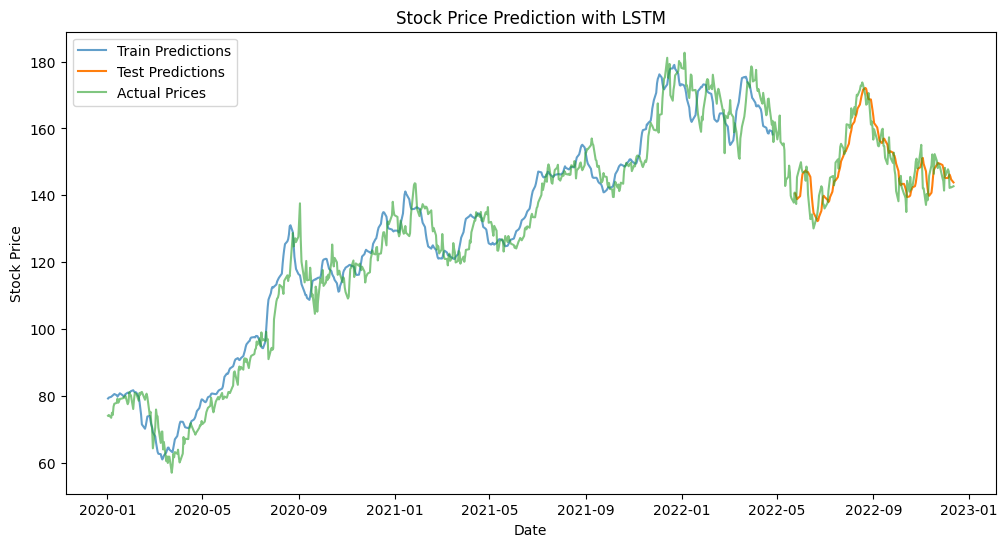

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(data_filtered.Date[:len(train_predictions)], train_predictions, label='Train Predictions', alpha=0.7)
plt.plot(data_filtered.Date[len(train_predictions)+ 2*SEQUENCE_LENGTH:], test_predictions, label='Test Predictions')
plt.plot(data_filtered.Date, data_open, label='Actual Prices', alpha=0.6)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.show()

## Saving the model

In the end I will save the entire model using **tf.keras.Model.save** to save a model's architecture, weights, and training configuration in a single model.keras zip archive

In [42]:
model.save('/content/drive/MyDrive/Projects/stock-price-prediction/stock-reg-model-lstm.h5')

I will also reload the model and evaluate it to be sure it was saved correctly

In [43]:
new_model = load_model('/content/drive/MyDrive/Projects/stock-price-prediction/stock-reg-model-lstm.h5')

new_model.summary() # Showing the model architecture

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 10, 64)            16896     
                                                                 
 lstm_41 (LSTM)              (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 25)                1625      
                                                                 
 dense_41 (Dense)            (None, 1)                 26        
                                                                 
Total params: 51,571
Trainable params: 51,571
Non-trainable params: 0
_________________________________________________________________


In [44]:
loss = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, loss: {:5.2f}%'.format(100 * loss))

print(new_model.predict(X_test).shape)

5/5 - 1s - loss: 0.0013 - 692ms/epoch - 138ms/step
Restored model, loss:  0.13%


5/5 [==============================] - 2s 6ms/step
(139, 1)
